In [1]:
!pip install datasets
!pip install tensorflow

In [2]:

from datasets import load_dataset

dataset = load_dataset('cifar10')

Reusing dataset cifar10 (/root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/5da9550526dac91579c0df95a56466f78e62cc6ea1ccffd17f71f2e64aa86b5e)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
print(dataset['train'].shape)
dataset['test'].shape

(50000, 2)


(10000, 2)

In [4]:
dataset['train'].features

{'img': Array3D(shape=(32, 32, 3), dtype='uint8', id=None),
 'label': ClassLabel(num_classes=10, names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], names_file=None, id=None)}

In [5]:
dataset['train']['label'][0]

0

In [6]:
import tensorflow as tf

In [7]:
import numpy as np

# Convert dataset into ndarrays

(train_x, train_y), (test_x, test_y) = \
  (np.array(dataset['train']['img']), np.array(dataset['train']['label'])), \
  (np.array(dataset['test']['img']), np.array(dataset['test']['label']))

# Scale input image pixel values

train_x, test_x = train_x / 255.0, test_x / 255.0

In [8]:
train_x[0]

array([[[0.69803922, 0.69019608, 0.74117647],
        [0.69803922, 0.69019608, 0.74117647],
        [0.69803922, 0.69019608, 0.74117647],
        ...,
        [0.66666667, 0.65882353, 0.70588235],
        [0.65882353, 0.65098039, 0.69411765],
        [0.64705882, 0.63921569, 0.68235294]],

       [[0.70588235, 0.69803922, 0.74901961],
        [0.70196078, 0.69411765, 0.74509804],
        [0.70588235, 0.69803922, 0.74901961],
        ...,
        [0.67843137, 0.67058824, 0.71372549],
        [0.67058824, 0.6627451 , 0.70588235],
        [0.65882353, 0.65098039, 0.69411765]],

       [[0.69411765, 0.68627451, 0.7372549 ],
        [0.69411765, 0.68627451, 0.7372549 ],
        [0.69803922, 0.69019608, 0.74117647],
        ...,
        [0.67058824, 0.6627451 , 0.70588235],
        [0.6627451 , 0.65490196, 0.69803922],
        [0.65490196, 0.64705882, 0.69019608]],

       ...,

       [[0.43921569, 0.41960784, 0.41960784],
        [0.44313725, 0.42745098, 0.42352941],
        [0.44705882, 0

In [16]:
import os

BATCH_SIZE = 96
DROPOUT_RATE = 0.1

def train_mobilenetv2(training=True):

  # Define callbacks for early training stopping and model checkpointing

  class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if logs.get('acc') > 0.3:
        print("\nReached stopping point accuracy.")
        self.model.stop_training = True

  early_stop_callback = Callback()

  checkpoint_path = "mobileNetV2/model.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)

  checkpointing_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_path, save_weights_only=True, verbose=1)

  # Define MobileNetV2

  # Initial 32-output channel convolution
  class initial_conv2d(tf.keras.Sequential):
    def __init__(self):
      tf.keras.Sequential.__init__(self, layers=[
        tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', 
                               activation=None, name='i_conv'),
        tf.keras.layers.BatchNormalization(momentum=0.999, name='i_bnorm'),
        tf.keras.layers.ReLU(max_value=6.0, name='i_relu'),
        # Dropout only during training
        # tf.keras.layers.Dropout(DROPOUT_RATE)
        ])
      
  # Final 1280-output channel convolution
  class final_conv2d(tf.keras.Sequential):
    def __init__(self):
      tf.keras.Sequential.__init__(self, layers=[
        tf.keras.layers.Conv2D(1280, (1, 1),
                               activation=None, name='f_conv'),
        tf.keras.layers.BatchNormalization(momentum=0.999, name='f_bnorm'),
        tf.keras.layers.ReLU(max_value=6.0, name='f_relu'),
        # Dropout only during training
        # tf.keras.layers.Dropout(DROPOUT_RATE)
        ])
      
  # MBConv inverted residual bottleneck layer
  def mbconv2d(input, expansion_factor=1, 
                 output_channels=16, stride=(1, 1), block_id=1):
      
      input_channels = input.shape[3]

      # Initial 1x1 convolution, multiplying the channel count by the 
      # expansion factor, widening the representation
      conv1 = tf.keras.layers.Conv2D(expansion_factor*input_channels, (1, 1), 
                              activation=None)(input)
      conv1 = tf.keras.layers.BatchNormalization(momentum=0.999)(conv1)
      conv1 = tf.keras.layers.ReLU(max_value=6.0)(conv1)
      # Dropout only during training
      # conv1 = tf.keras.layers.Dropout(DROPOUT_RATE)(conv1)
      
      # Subsequent 3x3 Depthwise convolution, applying an independent kernel
      # For each input channel. Stride automatically performs downsampling.
      dwconv1 = tf.keras.layers.DepthwiseConv2D((3, 3), stride, padding='same', 
                              activation='relu6')(conv1)
      dwconv1 = tf.keras.layers.BatchNormalization(momentum=0.999)(dwconv1)
      dwconv1 = tf.keras.layers.ReLU(max_value=6.0)(dwconv1)
      # Dropout only during training
      # dwconv1 = tf.keras.layers.Dropout(DROPOUT_RATE)(dwconv1)
      
      # Final 1x1 convolution, compressing the channel space into the output
      # Channel dimension. No nonlinear activation!
      conv2 = tf.keras.layers.Conv2D(output_channels, (1, 1),
                              activation=None)(dwconv1)
      conv2 = tf.keras.layers.BatchNormalization(momentum=0.999)(conv2)
      # Dropout only during training
      # conv2 = tf.keras.layers.Dropout(DROPOUT_RATE)(conv2)

      # Residual connection

      # As in ResNet, if the input and output dimensions to not line up, use
      # A linear transformation to map the identity into the output space
      # if input.shape != conv2.shape:
      #   input = tf.keras.layers.Conv2D(conv2.shape[3], (1, 1), 
      #       activation=None, name='IdentityConv_' + block_id)(input)
      #   input = tf.keras.layers.MaxPooling2D(pool_size=(
      #       input.shape[1] / conv2.shape[1], input.shape[2] / 
      #       conv2.shape[2]), name='IdentityMaxpool_' + block_id)(input)
      # return tf.keras.layers.Add()([input, conv2])

      # Or, just don't do the residual connection if input and output dims don't
      # Match up. (This is how the official implementation is done)
      if input_channels == output_channels and stride == (1, 1):
        return tf.keras.layers.Add(name='Residual_'+block_id)([input, conv2])
      else:
        return conv2


  # Input shape of CIFAR-10 image
  inputs = tf.keras.layers.Input(shape=(32, 32, 3))

  # Initial 32-output channel convolution
  conv1 = initial_conv2d()(inputs)

  # First MBConv series: (16, 16, 32) -> (16, 16, 16); t=1, c=16, n=1, s=1
  b1a = mbconv2d(conv1, expansion_factor=1, output_channels=16, 
                   stride=(1, 1), block_id='1a')
  
  # Second MBConv series: (16, 16, 16) -> (8, 8, 24); t=6, c=24, n=2, s=2
  b2a = mbconv2d(b1a, expansion_factor=6, output_channels=24, 
                   stride=(2, 2), block_id='2a')
  b2b = mbconv2d(b2a, expansion_factor=6, output_channels=24, 
                   stride=(1, 1), block_id='2b')
  
  # Third MBConv series: (8, 8, 24) -> (4, 4, 32); t=6, c=32, n=3, s=2
  b3a = mbconv2d(b2b, expansion_factor=6, output_channels=32, 
                   stride=(2, 2), block_id='3a')
  b3b = mbconv2d(b3a, expansion_factor=6, output_channels=32, 
                   stride=(1, 1), block_id='3b')
  b3c = mbconv2d(b3b, expansion_factor=6, output_channels=32, 
                   stride=(1, 1), block_id='3c')
  
  # Fourth MBConv series: (4, 4, 32) -> (2, 2, 64); t=6, c=64, n=4, s=2
  b4a = mbconv2d(b3c, expansion_factor=6, output_channels=64, 
                   stride=(2, 2), block_id='4a')
  b4b = mbconv2d(b4a, expansion_factor=6, output_channels=64, 
                   stride=(1, 1), block_id='4b')
  b4c = mbconv2d(b4b, expansion_factor=6, output_channels=64, 
                   stride=(1, 1), block_id='4c')
  b4d = mbconv2d(b4c, expansion_factor=6, output_channels=64, 
                   stride=(1, 1), block_id='4d')
  # Dropout locations taken from https://github.com/yumaloop/mobilenetV2-cifar/blob/master/models/mobilenet_v2.py
  b4d = tf.keras.layers.Dropout(DROPOUT_RATE)(b4d)
  
  # Fifth MBConv series: (2, 2, 64) -> (2, 2, 96); t=6, c=96, n=3, s=1
  b5a = mbconv2d(b4d, expansion_factor=6, output_channels=96, 
                   stride=(1, 1), block_id='5a')
  b5b = mbconv2d(b5a, expansion_factor=6, output_channels=96, 
                   stride=(1, 1), block_id='5b')
  b5c = mbconv2d(b5b, expansion_factor=6, output_channels=96, 
                   stride=(1, 1), block_id='5c')
  b5c = tf.keras.layers.Dropout(DROPOUT_RATE)(b5c)
  
  # Sixth MBConv series: (2, 2, 96) -> (1, 1, 160); t=6, c=160, n=3, s=2
  b6a = mbconv2d(b4d, expansion_factor=6, output_channels=160, 
                   stride=(1, 1), block_id='6a')
  b6b = mbconv2d(b5a, expansion_factor=6, output_channels=160, 
                   stride=(1, 1), block_id='6b')
  b6c = mbconv2d(b5b, expansion_factor=6, output_channels=160, 
                   stride=(1, 1), block_id='6c')
  b6c = tf.keras.layers.Dropout(DROPOUT_RATE)(b6c)
  
  # Seventh MBConv series: (1, 1, 160) -> (1, 1, 320); t=6, c=320, n=3, s=1
  b7a = mbconv2d(b4d, expansion_factor=6, output_channels=320, 
                   stride=(1, 1), block_id='7a')
  b7b = mbconv2d(b5a, expansion_factor=6, output_channels=320, 
                   stride=(1, 1), block_id='7b')
  b7c = mbconv2d(b5b, expansion_factor=6, output_channels=320, 
                   stride=(1, 1), block_id='7c')
  b7c = tf.keras.layers.Dropout(DROPOUT_RATE)(b7c)
  
  # Final convolution
  conv2 = final_conv2d()(b7c)

  # Dense layer and softmax
  flatten = tf.keras.layers.Flatten()(conv2)
  d2 = tf.keras.layers.Dense(10, activation=None)(flatten)
  d2 = tf.keras.layers.BatchNormalization(momentum=0.999)(d2)
  d2 = tf.keras.layers.Softmax()(d2)

  model = tf.keras.Model(inputs=inputs, outputs=d2)

  schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.045, 50000/BATCH_SIZE, 0.98, staircase=False, name='ExpDecaySchedule'
  )
  # optimizer = tf.keras.optimizers.RMSprop(learning_rate=schedule, rho=0.9)
  optimizer = tf.keras.optimizers.Adam(learning_rate=schedule)

  # Add weight decay of 0.00004 to all depthwise conv and conv2d layers
  for layer in model.layers:
    for attr in ['depthwise_regularizer', 'kernel_regularizer']:
      if hasattr(layer, attr):
        setattr(layer, attr, tf.keras.regularizers.L2(4e-5))
        print(layer.get_config())

  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
  
  model.summary()

  history = model.fit(train_x, train_y, epochs=300, callbacks=[
    # early_stop_callback, checkpointing_callback])
    checkpointing_callback], batch_size=BATCH_SIZE, 
    validation_data=(test_x, test_y))

  # Return metrics
  return history.epoch, history.history['accuracy'][-1]


In [ ]:
_, _ = train_mobilenetv2()

{'name': 'conv2d_114', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (1, 1), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L2', 'config': {'l2': 3.9999998989515007e-05}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'depthwise_conv2d_57', 'trainable': True, 'dtype': 'float32', 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu6', 'use_bias': True, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwis

In [ ]:
!pip install matplotlib

8

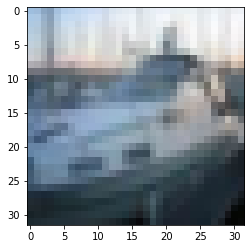

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(test_x[2])
test_y[2]

In [12]:
!zip -r /content/mobileNetV2.zip /content/mobileNetV2

  adding: content/mobileNetV2/ (stored 0%)
  adding: content/mobileNetV2/model.ckpt.index (deflated 80%)
  adding: content/mobileNetV2/model.ckpt.data-00000-of-00001 (deflated 39%)
  adding: content/mobileNetV2/checkpoint (deflated 42%)


In [16]:
# Initial 32-output channel convolution
class initial_conv2d(tf.keras.Sequential):
  def __init__(self):
    tf.keras.Sequential.__init__(self, layers=[
      tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', 
                              activation=None, name='i_conv'),
      tf.keras.layers.BatchNormalization(momentum=0.999, name='i_bnorm'),
      tf.keras.layers.ReLU(max_value=6.0, name='i_relu')
      ])
    
# Final 1280-output channel convolution
class final_conv2d(tf.keras.Sequential):
  def __init__(self):
    tf.keras.Sequential.__init__(self, layers=[
      tf.keras.layers.Conv2D(1280, (1, 1),
                              activation=None, name='f_conv'),
      tf.keras.layers.BatchNormalization(momentum=0.999, name='f_bnorm'),
      tf.keras.layers.ReLU(max_value=6.0, name='f_relu')
      ])
    
# MBConv inverted residual bottleneck layer
def mbconv2d(input, expansion_factor=1, 
                output_channels=16, stride=(1, 1), block_id=1):
    
    input_channels = input.shape[3]

    # Initial 1x1 convolution, multiplying the channel count by the 
    # expansion factor, widening the representation
    conv1 = tf.keras.layers.Conv2D(expansion_factor*input_channels, (1, 1), 
                            activation=None)(input)
    conv1 = tf.keras.layers.BatchNormalization(momentum=0.999)(conv1)
    conv1 = tf.keras.layers.ReLU(max_value=6.0)(conv1)
    
    # Subsequent 3x3 Depthwise convolution, applying an independent kernel
    # For each input channel. Stride automatically performs downsampling.
    dwconv1 = tf.keras.layers.DepthwiseConv2D((3, 3), stride, padding='same', 
                            activation='relu6')(conv1)
    dwconv1 = tf.keras.layers.BatchNormalization(momentum=0.999)(dwconv1)
    dwconv1 = tf.keras.layers.ReLU(max_value=6.0)(dwconv1)
    
    # Final 1x1 convolution, compressing the channel space into the output
    # Channel dimension. No nonlinear activation!
    conv2 = tf.keras.layers.Conv2D(output_channels, (1, 1),
                            activation=None)(dwconv1)
    conv2 = tf.keras.layers.BatchNormalization(momentum=0.999)(conv2)

    # Residual connection

    # As in ResNet, if the input and output dimensions to not line up, use
    # A linear transformation to map the identity into the output space
    # if input.shape != conv2.shape:
    #   input = tf.keras.layers.Conv2D(conv2.shape[3], (1, 1), 
    #       activation=None, name='IdentityConv_' + block_id)(input)
    #   input = tf.keras.layers.MaxPooling2D(pool_size=(
    #       input.shape[1] / conv2.shape[1], input.shape[2] / 
    #       conv2.shape[2]), name='IdentityMaxpool_' + block_id)(input)
    # return tf.keras.layers.Add()([input, conv2])

    # Or, just don't do the residual connection if input and output dims don't
    # Match up. (This is how the official implementation is done)
    if input_channels == output_channels and stride == (1, 1):
      return tf.keras.layers.Add(name='Residual_'+block_id)([input, conv2])
    else:
      return conv2


# Input shape of CIFAR-10 image
inputs = tf.keras.layers.Input(shape=(32, 32, 3))

# Initial 32-output channel convolution
conv1 = initial_conv2d()(inputs)

# First MBConv series: (16, 16, 32) -> (16, 16, 16); t=1, c=16, n=1, s=1
b1a = mbconv2d(conv1, expansion_factor=1, output_channels=16, 
                  stride=(1, 1), block_id='1a')

# Second MBConv series: (16, 16, 16) -> (8, 8, 24); t=6, c=24, n=2, s=2
b2a = mbconv2d(b1a, expansion_factor=6, output_channels=24, 
                  stride=(2, 2), block_id='2a')
b2b = mbconv2d(b2a, expansion_factor=6, output_channels=24, 
                  stride=(1, 1), block_id='2b')

# Third MBConv series: (8, 8, 24) -> (4, 4, 32); t=6, c=32, n=3, s=2
b3a = mbconv2d(b2b, expansion_factor=6, output_channels=32, 
                  stride=(2, 2), block_id='3a')
b3b = mbconv2d(b3a, expansion_factor=6, output_channels=32, 
                  stride=(1, 1), block_id='3b')
b3c = mbconv2d(b3b, expansion_factor=6, output_channels=32, 
                  stride=(1, 1), block_id='3c')

# Fourth MBConv series: (4, 4, 32) -> (2, 2, 64); t=6, c=64, n=4, s=2
b4a = mbconv2d(b3c, expansion_factor=6, output_channels=64, 
                  stride=(2, 2), block_id='4a')
b4b = mbconv2d(b4a, expansion_factor=6, output_channels=64, 
                  stride=(1, 1), block_id='4b')
b4c = mbconv2d(b4b, expansion_factor=6, output_channels=64, 
                  stride=(1, 1), block_id='4c')
b4d = mbconv2d(b4c, expansion_factor=6, output_channels=64, 
                  stride=(1, 1), block_id='4d')

# Fifth MBConv series: (2, 2, 64) -> (2, 2, 96); t=6, c=96, n=3, s=1
b5a = mbconv2d(b4d, expansion_factor=6, output_channels=96, 
                  stride=(1, 1), block_id='5a')
b5b = mbconv2d(b5a, expansion_factor=6, output_channels=96, 
                  stride=(1, 1), block_id='5b')
b5c = mbconv2d(b5b, expansion_factor=6, output_channels=96, 
                  stride=(1, 1), block_id='5c')

# Sixth MBConv series: (2, 2, 96) -> (1, 1, 160); t=6, c=160, n=3, s=2
b6a = mbconv2d(b4d, expansion_factor=6, output_channels=160, 
                  stride=(1, 1), block_id='6a')
b6b = mbconv2d(b5a, expansion_factor=6, output_channels=160, 
                  stride=(1, 1), block_id='6b')
b6c = mbconv2d(b5b, expansion_factor=6, output_channels=160, 
                  stride=(1, 1), block_id='6c')

# Seventh MBConv series: (1, 1, 160) -> (1, 1, 320); t=6, c=320, n=3, s=1
b7a = mbconv2d(b4d, expansion_factor=6, output_channels=320, 
                  stride=(1, 1), block_id='7a')
b7b = mbconv2d(b5a, expansion_factor=6, output_channels=320, 
                  stride=(1, 1), block_id='7b')
b7c = mbconv2d(b5b, expansion_factor=6, output_channels=320, 
                  stride=(1, 1), block_id='7c')

# Final convolution
conv2 = final_conv2d()(b7c)

# Dense layer and softmax
flatten = tf.keras.layers.Flatten()(conv2)
d2 = tf.keras.layers.Dense(10, activation=None)(flatten)
d2 = tf.keras.layers.BatchNormalization(momentum=0.999)(d2)
d2 = tf.keras.layers.Softmax()(d2)

model = tf.keras.Model(inputs=inputs, outputs=d2)

schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  0.045, 50000/BATCH_SIZE, 0.98, staircase=False, name='ExpDecaySchedule'
)
optimizer = tf.keras.optimizers.Adam(learning_rate=schedule)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
  
model.load_weights('mobileNetV2/model.ckpt')

In [17]:
model.evaluate(test_x, test_y, verbose=2)

313/313 - 5s - loss: 1.4163 - accuracy: 0.6778 - 5s/epoch - 17ms/step


[1.4163216352462769, 0.6777999997138977]